# Drzewa decyzyjne

## Wprowadzenie

Drzewa decyzyjne to graficzne reprezentacje algorytmu uczenia nadzorowanego, wykorzystywanego do klasyfikacji 
i modelowania regresji. 

Struktura składa się z węzłów, gałęzi i liści, gdzie w każdym węźle sprawdzany jest warunek decydujący o dalszej ścieżce. 

Ta efektywna metoda analizy danych pozwala na zrozumienie zależności między zmiennymi, a schemat blokowy drzewa ułatwia interpretację procesu decyzyjnego. 

## Zastosowanie

Drzewa decyzyjne znajdują praktyczne zastosowanie w różnego rodzaju problemach decyzyjnych, szczególnie takich gdzie występuje dużo rozgałęziających się wariantów a także w warunkach ryzyka.

Drzewa decyzyjne znajdują szerokie zastosowanie 
w problemach związanych z klasyfikacją i predykcją pojęć typu:
- Diagnostyka medyczna
- Przewidywanie
- Akceptacja i udzielanie kredytów

## Zalety i wady

### Zalety:
- Pozwalają opisywać skomplikowane wydarzenia w prosty sposób
- Nie zajmują wiele pamięci obliczeniowej
- Pozwalają na podejmowanie szybkich decyzji (im więcej warunków, tym dłuższy czas)
- Proste do zrozumienia, intuicyjne
- Łatwość zmiany

### Wady:
- Testowanie jednego atrybutu na raz
- Kosztowna reprezentacja alternatyw pomiędzy atrybutami
- Brak łatwej możliwości inkrementacyjnego aktualizowania

## Drzewa klasyfikacyjne

Drzewa klasyfikacyjne są używane do przyporządkowywania przypadków do klas na podstawie pomiarów zmiennych objaśniających, umożliwiając konstrukcję przejrzystych reguł klasyfikacyjnych. 

Są szczególnie efektywne w zadaniach z dużymi zbiorami danych, takich jak klasyfikacja kredytobiorców czy predykcja zachowań klientów. 

Drzewa klasyfikacyjne decydują, czy określone zdarzenie występuje, reprezentując wynik jako "tak" lub "nie".

### Wczytanie bibliotek

In [47]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pyspark.sql.functions import col, sum
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from sklearn.tree import plot_tree
from sklearn import tree
from pyspark.ml import PipelineModel
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
import os

### Inicjalizacja sesji Spark

In [2]:
spark = SparkSession.builder.appName("example").getOrCreate()

24/01/17 19:53:30 WARN Utils: Your hostname, Zuzas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.102 instead (on interface en0)
24/01/17 19:53:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/17 19:53:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Załadowanie danych

In [3]:
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['target'] = iris.target
spark_df_iris = spark.createDataFrame(df_iris)
spark_df_iris.show(5)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
|              4.7|             3.2|              1.3|             0.2|     0|
|              4.6|             3.1|              1.5|             0.2|     0|
|              5.0|             3.6|              1.4|             0.2|     0|
+-----------------+----------------+-----------------+----------------+------+
only showing top 5 rows



#### Gatunki irysów (kolumna target):
- Klasa 0: setosa,
- Klasa 1: virginica,
- Klasa 2: versicolor.

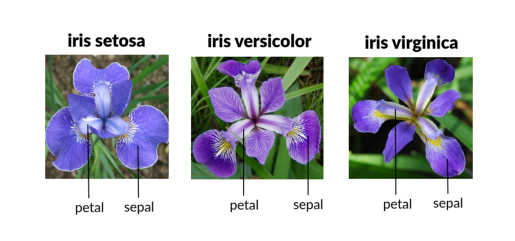

In [4]:
image_path = "/Users/zuzapiekarczyk/Downloads/51518iris img1.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

#### Liczebność irysów w podziale na gatunki

In [5]:
distinct_values_count = spark_df_iris.select('target').distinct().count()
occurrences_count = spark_df_iris.groupBy('target').count()
print("Liczba różnych wartości w kolumnie 'target':", distinct_values_count)
print("\nIlość wystąpień każdej wartości:")
occurrences_count.show()

Liczba różnych wartości w kolumnie 'target': 3

Ilość wystąpień każdej wartości:
+------+-----+
|target|count|
+------+-----+
|     0|   50|
|     1|   50|
|     2|   50|
+------+-----+



### Eksploracja danych

In [6]:
spark_df_iris.printSchema()

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- target: long (nullable = true)



In [7]:
spark_df_iris.describe().show()

24/01/17 19:53:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|            target|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333334|3.0573333333333332|3.7580000000000005|1.1993333333333331|               1.0|
| stddev|0.8280661279778632|0.4358662849366984| 1.765298233259466|0.7622376689603464|0.8192319205190405|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



In [8]:
missing_values_count = spark_df_iris.select([sum(col(c).isNull().cast("int")).alias(c) for c in spark_df_iris.columns]).collect()
print("Ilość brakujących wartości w PySpark:")
for row in missing_values_count:
    print(row.asDict())

Ilość brakujących wartości w PySpark:
{'sepal length (cm)': 0, 'sepal width (cm)': 0, 'petal length (cm)': 0, 'petal width (cm)': 0, 'target': 0}


#### Wykres punktowy zależności długości płatka w funkcji szerokości płatka, dane różnicowane za pomocą gatunku/rodzaju

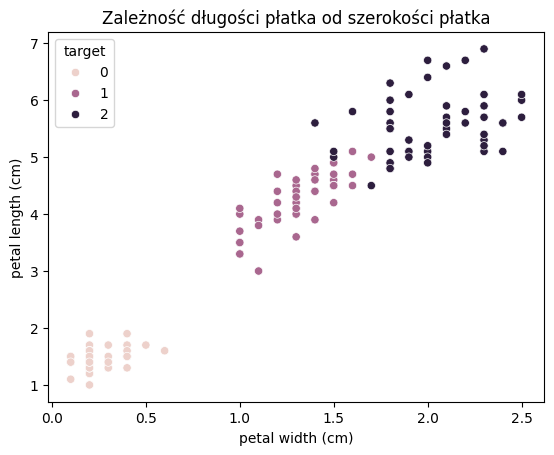

In [9]:
sns.scatterplot(x='petal width (cm)', y='petal length (cm)', hue='target', data=df_iris)
plt.title('Zależność długości płatka od szerokości płatka')
plt.show()

#### Wykres punktowy zależności długości kielicha w funkcji szerokości kielicha, dane różnicowane za pomocą gatunku/rodzaju

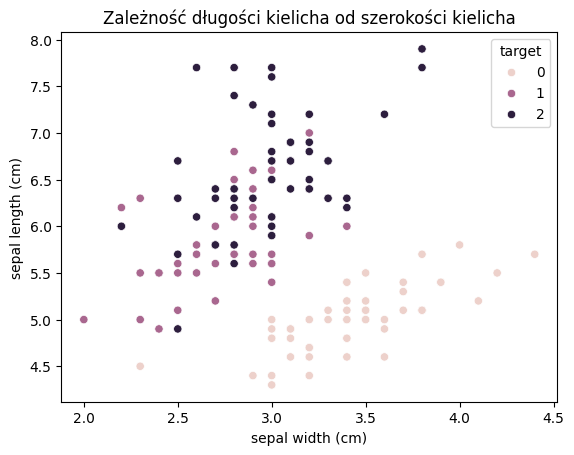

In [10]:
sns.scatterplot(x='sepal width (cm)', y='sepal length (cm)', hue='target', data=df_iris)
plt.title('Zależność długości kielicha od szerokości kielicha')
plt.show()

#### Wykres porównawczy składający się z macierzy par wszystkich zmiennych, różnicowanych na podstawie kolumny 'species'

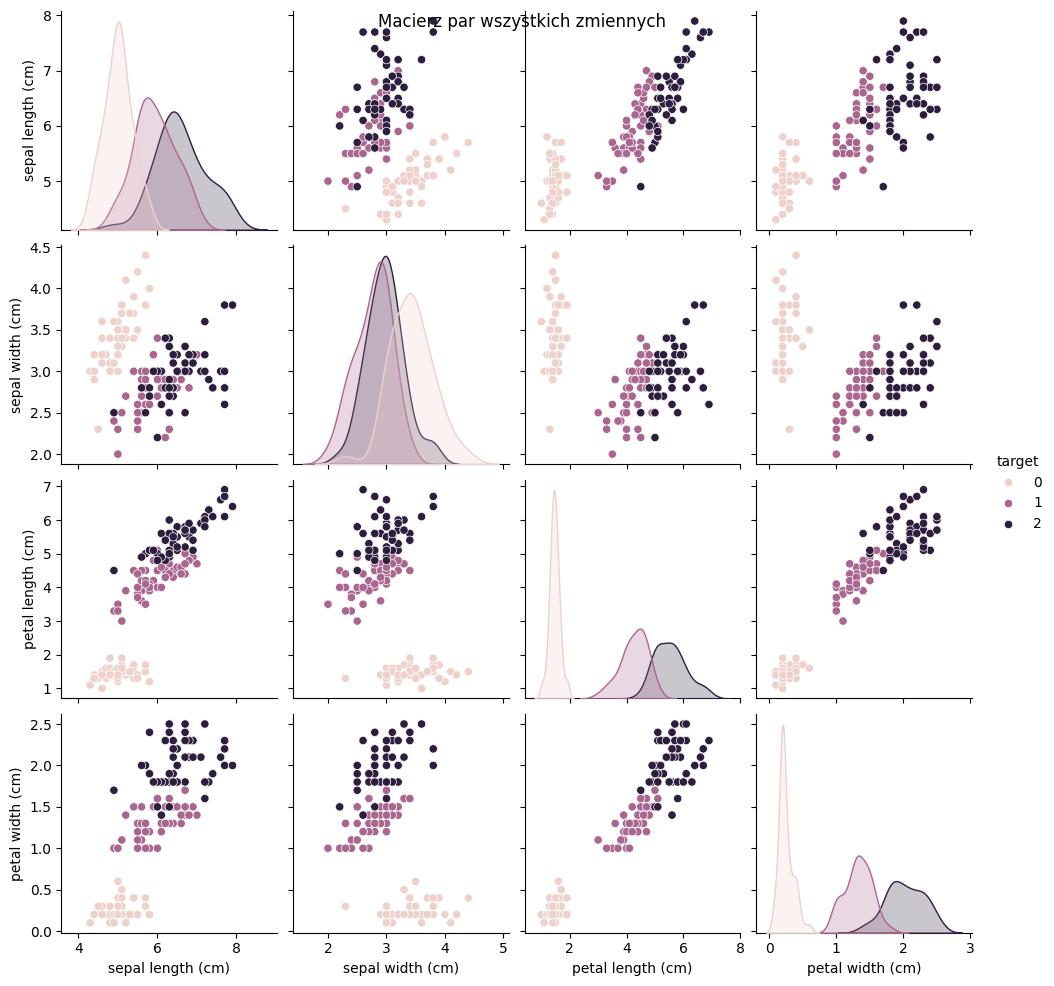

In [11]:
sns.pairplot(df_iris, hue='target')
plt.suptitle("Macierz par wszystkich zmiennych")
plt.show()

#### Mapa (heatmapa) korelacji

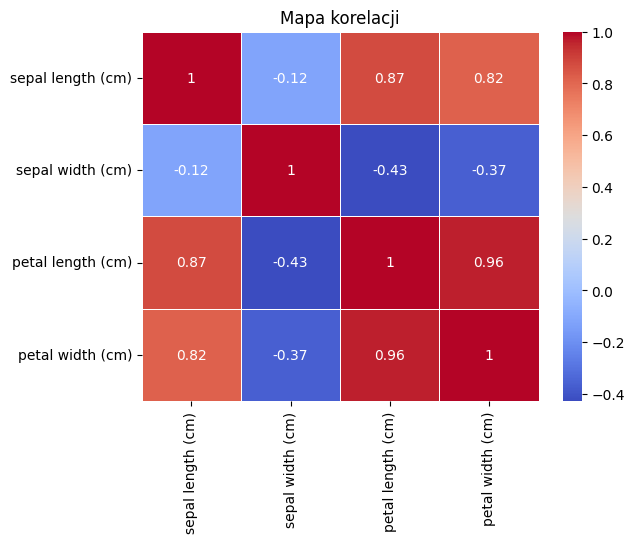

In [12]:
correlation_matrix_df = df_iris.drop('target',axis=1)
correlation_matrix=correlation_matrix_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Mapa korelacji")
plt.show()

### Wybranie cech i etykiet

In [13]:
vector_assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
spark_df_iris = vector_assembler.transform(spark_df_iris)

### Podział zbioru na podzbiór treningowy i testowy: zbiór testowy stanowi 20% całego zbioru danych

In [14]:
train_data, test_data = spark_df_iris.randomSplit([0.8, 0.2], seed=42)

### Budowa klasyfikatora drzewa decyzyjnego
- max_depth: ile kazdy węzeł moze mieć dzieci
- min_samples_leaf: minimalna ilość próbek do utworzenia liścia

In [15]:
tree_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="target", maxDepth=1, seed=101, minInstancesPerNode=2)

### Wytrenowanie modelu

In [16]:
tree_model = tree_classifier.fit(train_data)

### Wypróbowanie modelu na zbiorze testowym

In [17]:
tree_model_predictions = tree_model.transform(test_data)


### Ocena modelu

In [18]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="accuracy")
accuracy = evaluator.evaluate(tree_model_predictions)

print(f"Accuracy: {accuracy}")


Accuracy: 0.6176470588235294


In [19]:
correct_predictions = tree_model_predictions.filter(col("target") == col("prediction")).count()
total_predictions = tree_model_predictions.count()
precision = correct_predictions / total_predictions
print("Precision:", precision)

Precision: 0.6176470588235294


In [20]:
prediction_and_label = tree_model_predictions.select("prediction", "target").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[13.,  0.,  0.],
             [ 0.,  8.,  0.],
             [ 0., 13.,  0.]])


##### Precision (precyzja) o wartości 0.62 oznacza, że dla danego modelu klasyfikacyjnego, który został użyty do klasyfikacji wieloklasowej, około 62% przypadków sklasyfikowanych jako pozytywne są poprawnie sklasyfikowane.

##### Confusion Matrix (Macierz błędów):
- Klasa 0 (pierwsza kolumna): 13 przypadków poprawnie sklasyfikowanych, 0 przypadków fałszywie sklasyfikowanych jako klasa 0, 0 przypadków fałszywie sklasyfikowanych jako inne klasy.
- Klasa 1 (druga kolumna): 8 przypadków poprawnie sklasyfikowanych, 0 przypadków fałszywie sklasyfikowanych jako klasa 1, 0 przypadków fałszywie sklasyfikowanych jako inne klasy.
- Klasa 2 (trzecia kolumna): 0 przypadków poprawnie sklasyfikowanych, 13 przypadków fałszywie sklasyfikowanych jako klasa 2, 0 przypadków fałszywie sklasyfikowanych jako inne klasy.

In [26]:
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="target")
pipeline = Pipeline(stages=[dt_classifier])

param_grid = ParamGridBuilder().addGrid(dt_classifier.maxDepth, [1, 2, 3, 4, 5, 7, 10, 12]) \
                                .addGrid(dt_classifier.minInstancesPerNode, [1, 2, 3, 4, 5, 6, 8, 10]) \
                                .build()

cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy"),
                                 numFolds=5)

cv_model = cross_validator.fit(train_data)
predictions = cv_model.transform(test_data)

accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [27]:
correct_predictions = predictions.filter(col("target") == col("prediction")).count()
total_predictions = predictions.count()
precision = correct_predictions / total_predictions
print("Precision:", precision)

Precision: 1.0


In [28]:
prediction_and_label = predictions.select("prediction", "target").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[13.,  0.,  0.],
             [ 0.,  8.,  0.],
             [ 0.,  0., 13.]])


In [31]:
best_model = cv_model.bestModel

best_max_depth = best_model.stages[0].getOrDefault("maxDepth")
best_min_instances_per_node = best_model.stages[0].getOrDefault("minInstancesPerNode")

print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Instances Per Node: {best_min_instances_per_node}")

Best Max Depth: 3
Best Min Instances Per Node: 1


##### Optymalne drzewo regresji zostało osiągnięte przy użyciu parametrów 'max_depth' równego 3 i 'min_samples_leaf' równego 1.Precision dla ostatecznego modelu wynosi 1.0, co oznacza, że dla klasyfikacji wieloklasowej model poprawnie sklasyfikował wszystkie przypadki.
##### Confusion Matrix:
- Klasa 0: 13 poprawnych przewidywań,
- Klasa 1: 8 poprawnych przewidywań,
- Klasa 2: 13 poprawnych przewidywań.

### Wizualizacja predykcji

In [40]:
best_model = cv_model.bestModel
final_tree_classifier = best_model.stages[0]
tree_structure = final_tree_classifier._java_obj.toDebugString()

print("Decision Tree Structure:")
print(tree_structure)

Decision Tree Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f4506332d10a, depth=3, numNodes=9, numClasses=3, numFeatures=4
  If (feature 2 <= 2.5999999999999996)
   Predict: 0.0
  Else (feature 2 > 2.5999999999999996)
   If (feature 2 <= 4.75)
    If (feature 3 <= 1.65)
     Predict: 1.0
    Else (feature 3 > 1.65)
     Predict: 2.0
   Else (feature 2 > 4.75)
    If (feature 3 <= 1.75)
     Predict: 1.0
    Else (feature 3 > 1.75)
     Predict: 2.0



## Drzewa regresyjne

Drzewo regresji opiera się na analizie regresji i sumie kwadratów, przewidując wartości zmiennej zależnej w oparciu o kombinację zmiennych wejściowych. 

W przypadku drzewa regresyjnego, predykcje dotyczą przewidywanej średniej dla każdego węzła, zwłaszcza gdy zmienna przewidywana jest ciągła. 

Jakość predykcji drzewa regresji ocenia się wskaźnikiem R2, im wyższy R2 tym lepiej model radzi sobie z przewidywaniem zmienności docelowej zmiennej.

### Generowanie danych

In [48]:
X = list(range(300))
random = [np.random.randn(1)[0] * 10000 for _ in range(300)]
y = [float(x**2 + r) for x, r in zip(X, random)]

### Połączenie danych i przekształcenie na dataframe

In [49]:
data = list(zip(X, y))
schema = StructType([
    StructField("X", IntegerType(), True),
    StructField("y", DoubleType(), True)
])
df = spark.createDataFrame(data, schema)

### Zapisanie wygenerowanych danych do csv

In [50]:
csv_path = "/Users/zuzapiekarczyk/Downloads/data_reg.csv"
df.write.csv(csv_path, header=True, mode="overwrite")

### Wczytanie danych

In [52]:
df_loaded = spark.read.csv(csv_path, header=True, inferSchema=True)
df_loaded.show(5)

+---+------------------+
|  X|                 y|
+---+------------------+
|259| 65194.39980291971|
|260|63528.334402875276|
|261| 71649.76181971523|
|262| 71275.95578244042|
|263|  77638.4365725345|
+---+------------------+
only showing top 5 rows



### Eksploracja danych

In [53]:
df.printSchema()

root
 |-- X: integer (nullable = true)
 |-- y: double (nullable = true)



In [54]:
df.describe().show()

+-------+-----------------+-------------------+
|summary|                X|                  y|
+-------+-----------------+-------------------+
|  count|              300|                300|
|   mean|            149.5| 29407.561676377703|
| stddev|86.74675786448736| 28712.579432691076|
|    min|                0|-18768.855789877853|
|    max|              299| 103774.12451679225|
+-------+-----------------+-------------------+



In [55]:
missing_data_counts = df.select([col(c).alias(c) for c in df.columns]).select([col(c).isNull().cast("int").alias(c) for c in df.columns]).groupBy().sum().collect()
for col_name, count in zip(df.columns, missing_data_counts[0]):
    print(f"{col_name}: {count}")

X: 0
y: 0


#### Wykres punktowy zależności zmiennej y od zmiennej x

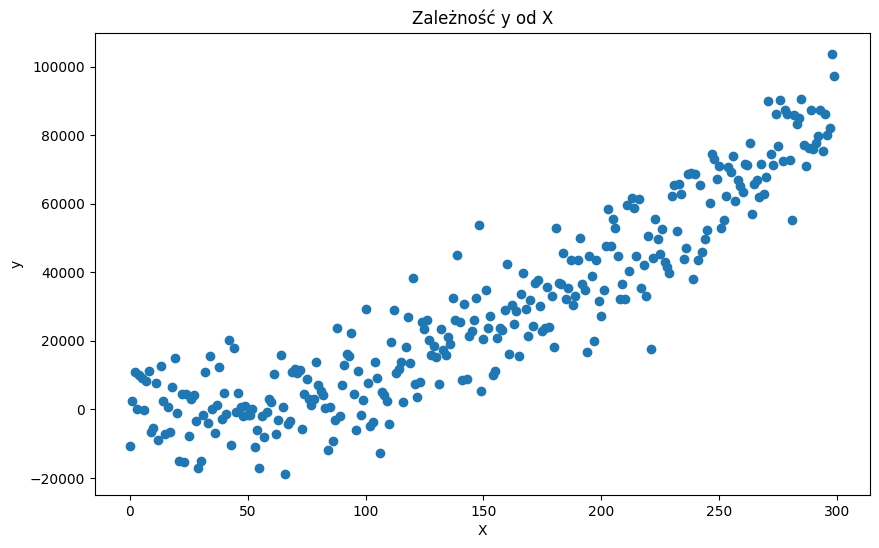

In [56]:
df_pandas = df.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['X'], df_pandas['y'])
plt.title('Zależność y od X')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### Przektszałcenie X w tablicę dwuwymiarową, ale z jedną kolumną

In [57]:
assembler = VectorAssembler(inputCols=["X"], outputCol="X_vector")
df_transformed = assembler.transform(df)
df_transformed.show(5)

+---+-------------------+--------+
|  X|                  y|X_vector|
+---+-------------------+--------+
|  0|-10691.745218596194|   [0.0]|
|  1|  2463.600776233384|   [1.0]|
|  2| 10939.175731842772|   [2.0]|
|  3|  4.033590748718152|   [3.0]|
|  4|  9974.127550132822|   [4.0]|
+---+-------------------+--------+
only showing top 5 rows



### Podział zbioru na podzbiór treningowy i testowy: zbiór testowy stanowi 20% całego zbioru danych

In [58]:
(training_data, testing_data) = df_transformed.randomSplit([0.8, 0.2], seed=42)

### Budowa klasyfikatora drzewa regresyjnego

In [59]:
reg = DecisionTreeRegressor(maxDepth=3, seed=30, minInstancesPerNode=2, featuresCol="X_vector", labelCol="y")

### Wytrenowanie modelu

In [60]:
reg_model = reg.fit(training_data)

In [63]:
training_data.show()

+---+-------------------+--------+
|  X|                  y|X_vector|
+---+-------------------+--------+
|  0|-10691.745218596194|   [0.0]|
|  1|  2463.600776233384|   [1.0]|
|  3|  4.033590748718152|   [3.0]|
|  4|  9974.127550132822|   [4.0]|
|  5|   9151.39266208141|   [5.0]|
|  7|  8291.543890621786|   [7.0]|
|  9| -6578.102145743985|   [9.0]|
| 10| -5491.059748160554|  [10.0]|
| 11|  7572.289941717441|  [11.0]|
| 12| -9042.502461599606|  [12.0]|
| 14| 2319.5036198019498|  [14.0]|
| 15| -7286.268721950437|  [15.0]|
| 16|  828.6816215497648|  [16.0]|
| 17| -6647.701058573238|  [17.0]|
| 18|  6668.003810254214|  [18.0]|
| 20| -925.8868479046034|  [20.0]|
| 21| -15140.80802761332|  [21.0]|
| 22|  4601.558883887071|  [22.0]|
| 24|  4556.331725770368|  [24.0]|
| 25| -7621.588872090577|  [25.0]|
+---+-------------------+--------+
only showing top 20 rows



### Wypróbowanie modelu na zbiorze testowym

In [66]:
predictions = reg_model.transform(testing_data)
predictions.select("X_vector", "y", "prediction").show(5)

+--------+-------------------+-----------------+
|X_vector|                  y|       prediction|
+--------+-------------------+-----------------+
|   [2.0]| 10939.175731842772|538.7977493593411|
|   [6.0]|-285.93220688594386|538.7977493593411|
|   [8.0]| 11184.913248267108|538.7977493593411|
|  [13.0]| 12526.306094442212|538.7977493593411|
|  [19.0]| 14999.570831944533|538.7977493593411|
+--------+-------------------+-----------------+
only showing top 5 rows



### Ocena modelu

In [67]:
evaluator = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

mae_evaluator = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)

print("R^2:", r2)
print("MAE:", mae)

R^2: 0.8690148125990882
MAE: 8619.074615968004


##### Wartość R-kwadrat (R2) wynosi 0.87, co oznacza, że model regresji liniowej jest w stanie wytłumaczyć około 87% zmienności w danych, co wskazuje na wysoką skuteczność modelu w predykcji wartości y. Średni błąd absolutny (MAE) wynosi 8619.07, co oznacza, że średnia różnica między rzeczywistymi a przewidywanymi y wynosi około 8619.07.

### Wizualizacja predykcji

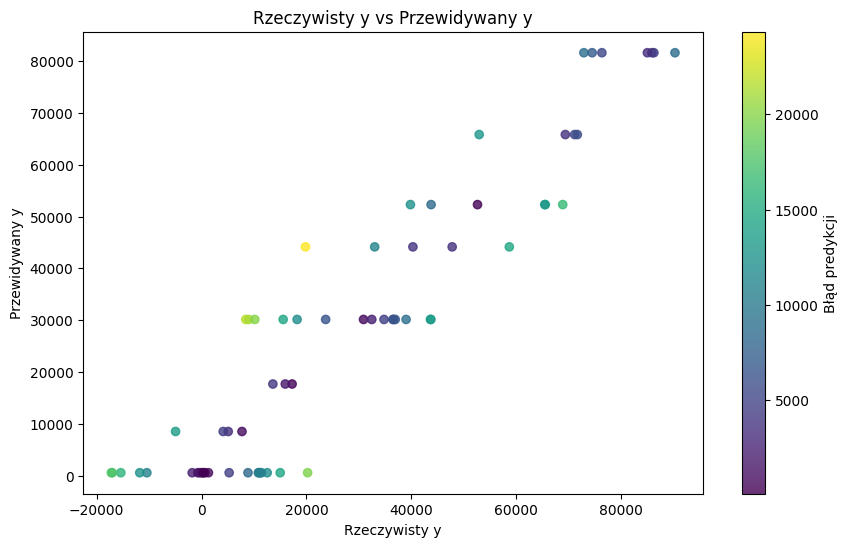

In [68]:
predictions_pandas = predictions.select("y", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas['y'], predictions_pandas['prediction'], c=np.abs(predictions_pandas['prediction'] - predictions_pandas['y']), cmap='viridis', alpha=0.8)
plt.colorbar(label='Błąd predykcji')
plt.xlabel("Rzeczywisty y")
plt.ylabel("Przewidywany y")
plt.title("Rzeczywisty y vs Przewidywany y")
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [70]:
dot_data = reg_model._java_obj.toDebugString()
print(dot_data)

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_8963cd6e8c0e, depth=3, numNodes=15, numFeatures=1
  If (feature 0 <= 196.5)
   If (feature 0 <= 112.5)
    If (feature 0 <= 86.5)
     Predict: 538.7977493593411
    Else (feature 0 > 86.5)
     Predict: 8500.776360125512
   Else (feature 0 > 112.5)
    If (feature 0 <= 137.5)
     Predict: 17669.87583821689
    Else (feature 0 > 137.5)
     Predict: 30135.386786772324
  Else (feature 0 > 196.5)
   If (feature 0 <= 244.5)
    If (feature 0 <= 223.5)
     Predict: 44150.580904278795
    Else (feature 0 > 223.5)
     Predict: 52312.87941316395
   Else (feature 0 > 244.5)
    If (feature 0 <= 270.5)
     Predict: 65838.67724803984
    Else (feature 0 > 270.5)
     Predict: 81640.21385730153

